- references
    - https://github.com/microsoft/DeepSpeed
        - https://www.microsoft.com/en-us/research/blog/turing-nlg-a-17-billion-parameter-language-model-by-microsoft/
    - huggingface DeepSpeed Integration
        - https://huggingface.co/docs/transformers/main_classes/deepspeed
    - cli
        - https://colab.research.google.com/github/stas00/porting/blob/master/transformers/deepspeed/DeepSpeed_on_colab_CLI.ipynb#scrollTo=vSlYvQWLwblN

In [1]:
from IPython.display import Image

## basics

- 三篇论文（**Ze**ro **R**edundancy **O**ptimizer）：
    - ZeRO: Memory Optimizations Toward Training Trillion Parameter Models
        - https://arxiv.org/abs/1910.02054
    - ZeRO-Infinity: Breaking the GPU Memory Wall for Extreme Scale Deep Learning
        - https://arxiv.org/abs/2104.07857
    - ZeRO-Offload: Democratizing Billion-Scale Model Training
        - https://arxiv.org/abs/2101.06840
- DeepSpeed
    - Optimizer state partitioning (ZeRO stage 1)
    - Gradient partitioning (ZeRO stage 2)
    - Parameter partitioning (ZeRO stage 3)
    - Custom mixed precision training handling
    - A range of fast CUDA-extension-based optimizers
    - ZeRO-Offload to CPU and NVMe
- 安装
    - 安装之后的检验，命令行执行 `ds_report`（ds：deepseed）；
    - 除此之外还有
        - `ds_accelearator`：setting ds_accelerator to cuda (auto_detect)
- 其他
    - sparse attention：https://www.deepspeed.ai/2020/09/08/sparse-attention.html
        - 10x longer seq，up to 6x faster；

In [3]:
# !ds_report

## os + g + p

In [5]:
Image(url='https://www.microsoft.com/en-us/research/uploads/prod/2020/02/DeepSpeed-Image-1.png', width=800)

- #p == #g
    - fp16 Parameters: 2bytes
    - fp16 Gradients: 2bytes
- K is the optimizer specific constant term. 
    - K = 12
    - fp32 Parameters: 4 bytes
    - fp32 Gradients (mean): 4 bytes
    -  fp32 Gradients (variance): 4 bytes

In [7]:
K = 12
psi = 7_500_000_000
N_d = 64

print((2 + 2 + K) * psi / 10**9)
print((2*psi + 2*psi + K*psi/N_d) / 10**9)
print((2*psi + (2+K)*psi/N_d) / 10**9)
print((2+2+K)*psi / N_d / 10**9)

120.0
31.40625
16.640625
1.875


In [4]:
Image(url='https://miro.medium.com/v2/resize:fit:1400/format:webp/1*QlAuDP1E70FsldhBRsaALw.png', width=800)

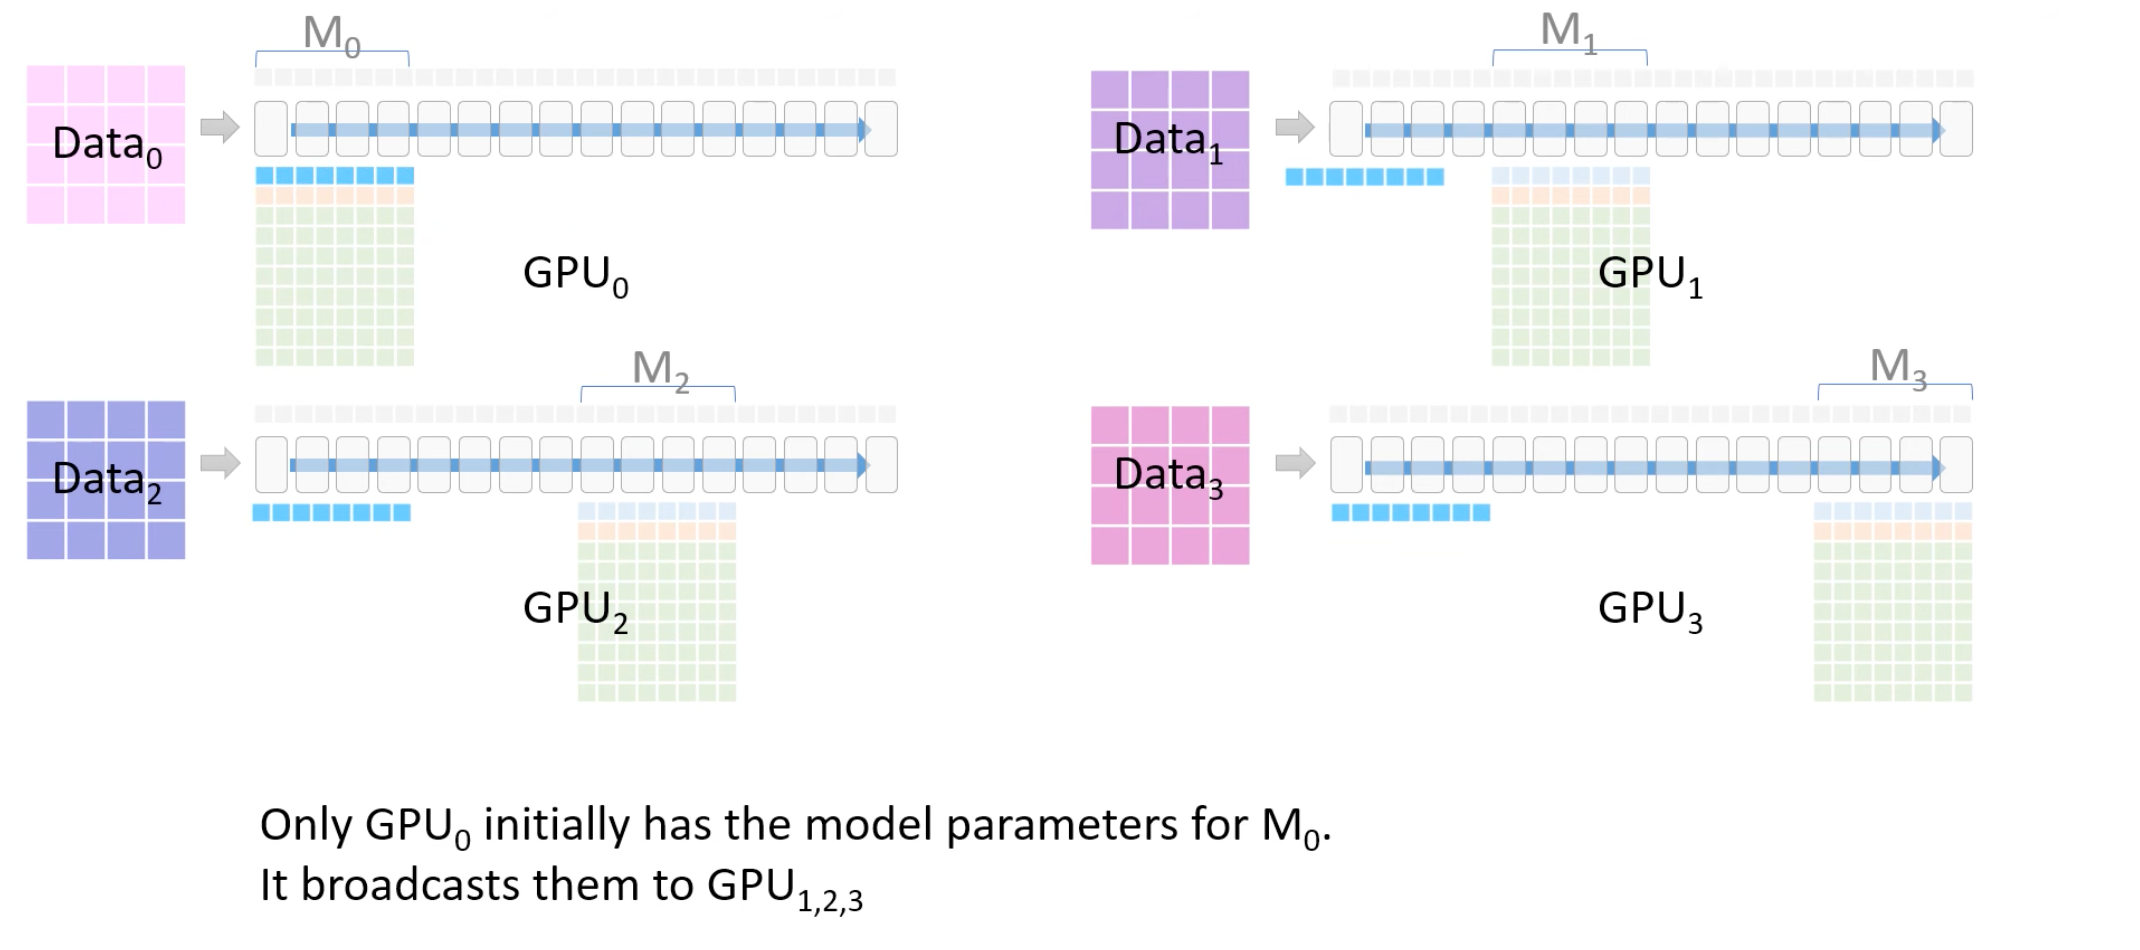

In [5]:
Image('../../imgs/m0_broadcast.png', width=700)

# all gpus have M0's parameters
# GPU1,2,3 store them in a temporary buffer;

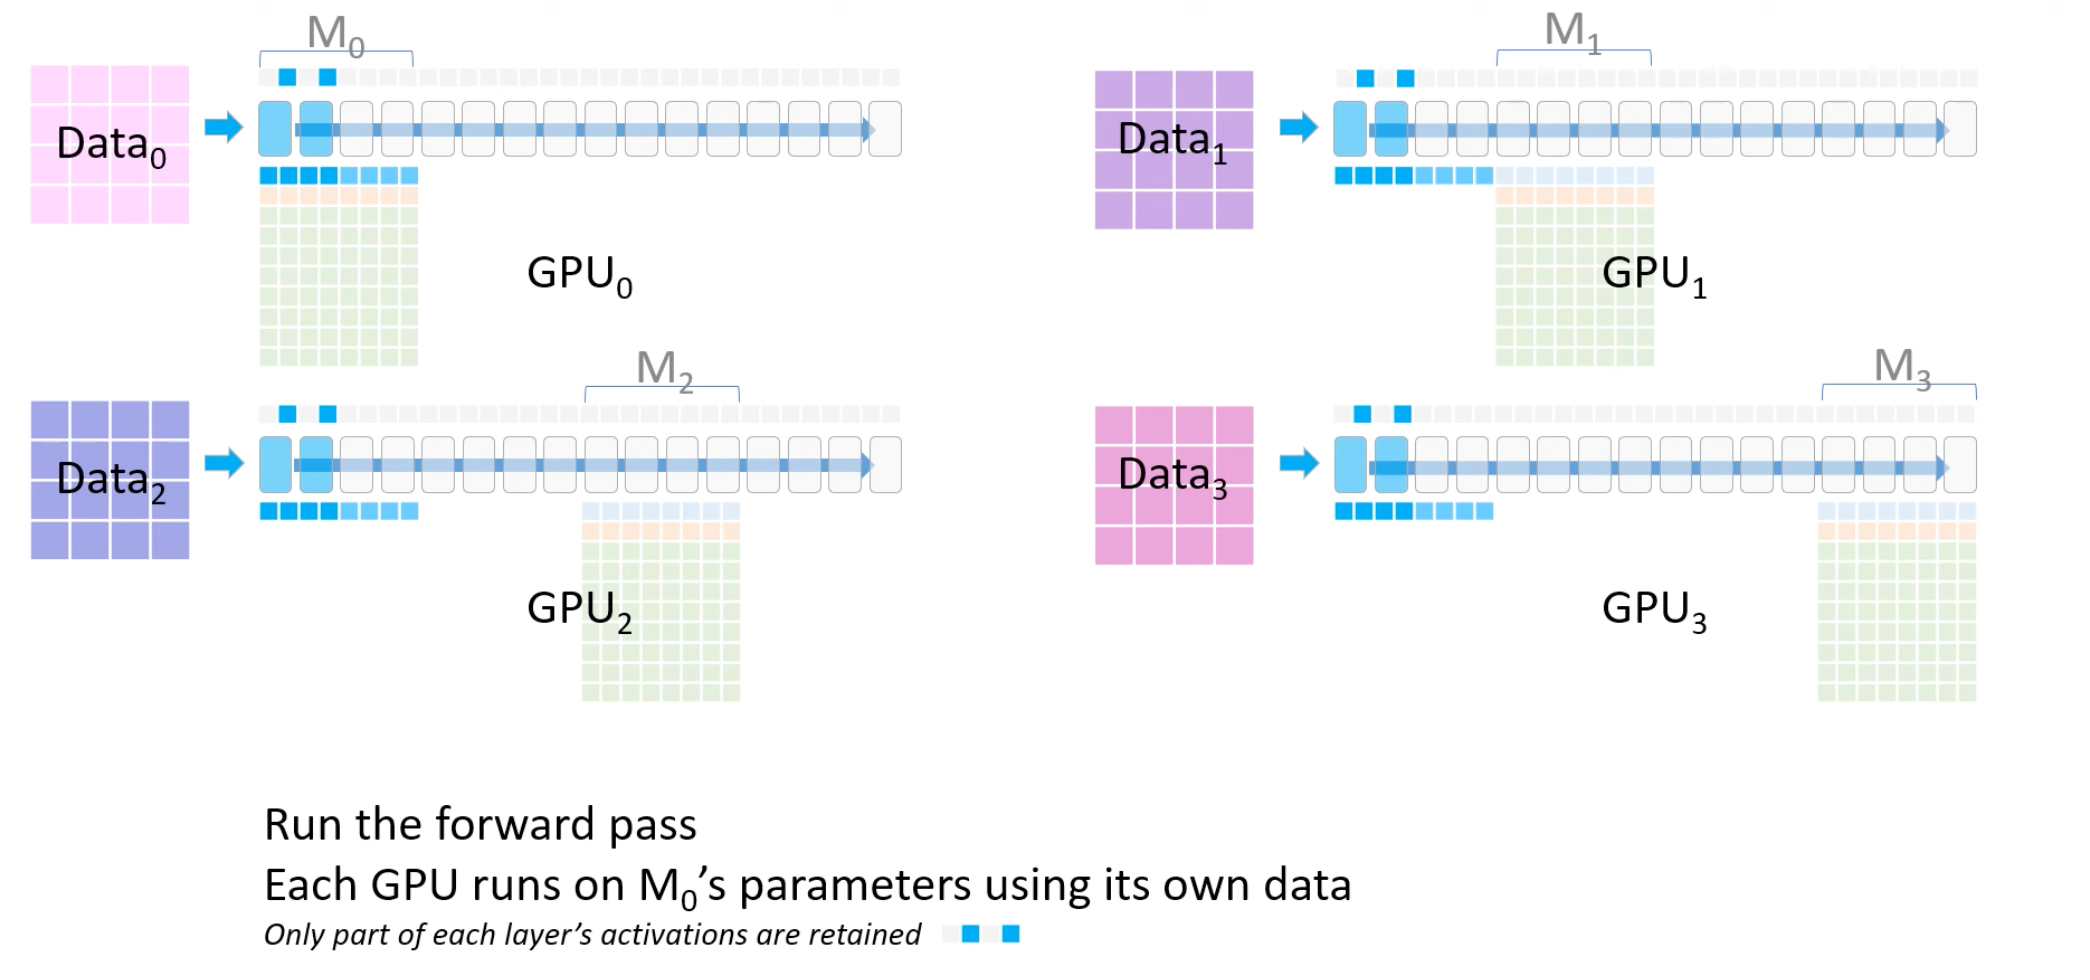

In [8]:
Image('../../imgs/m0_forward.png', width=700)
# once M0 is complete, GPU1,2,3 can delete the parameters for M0

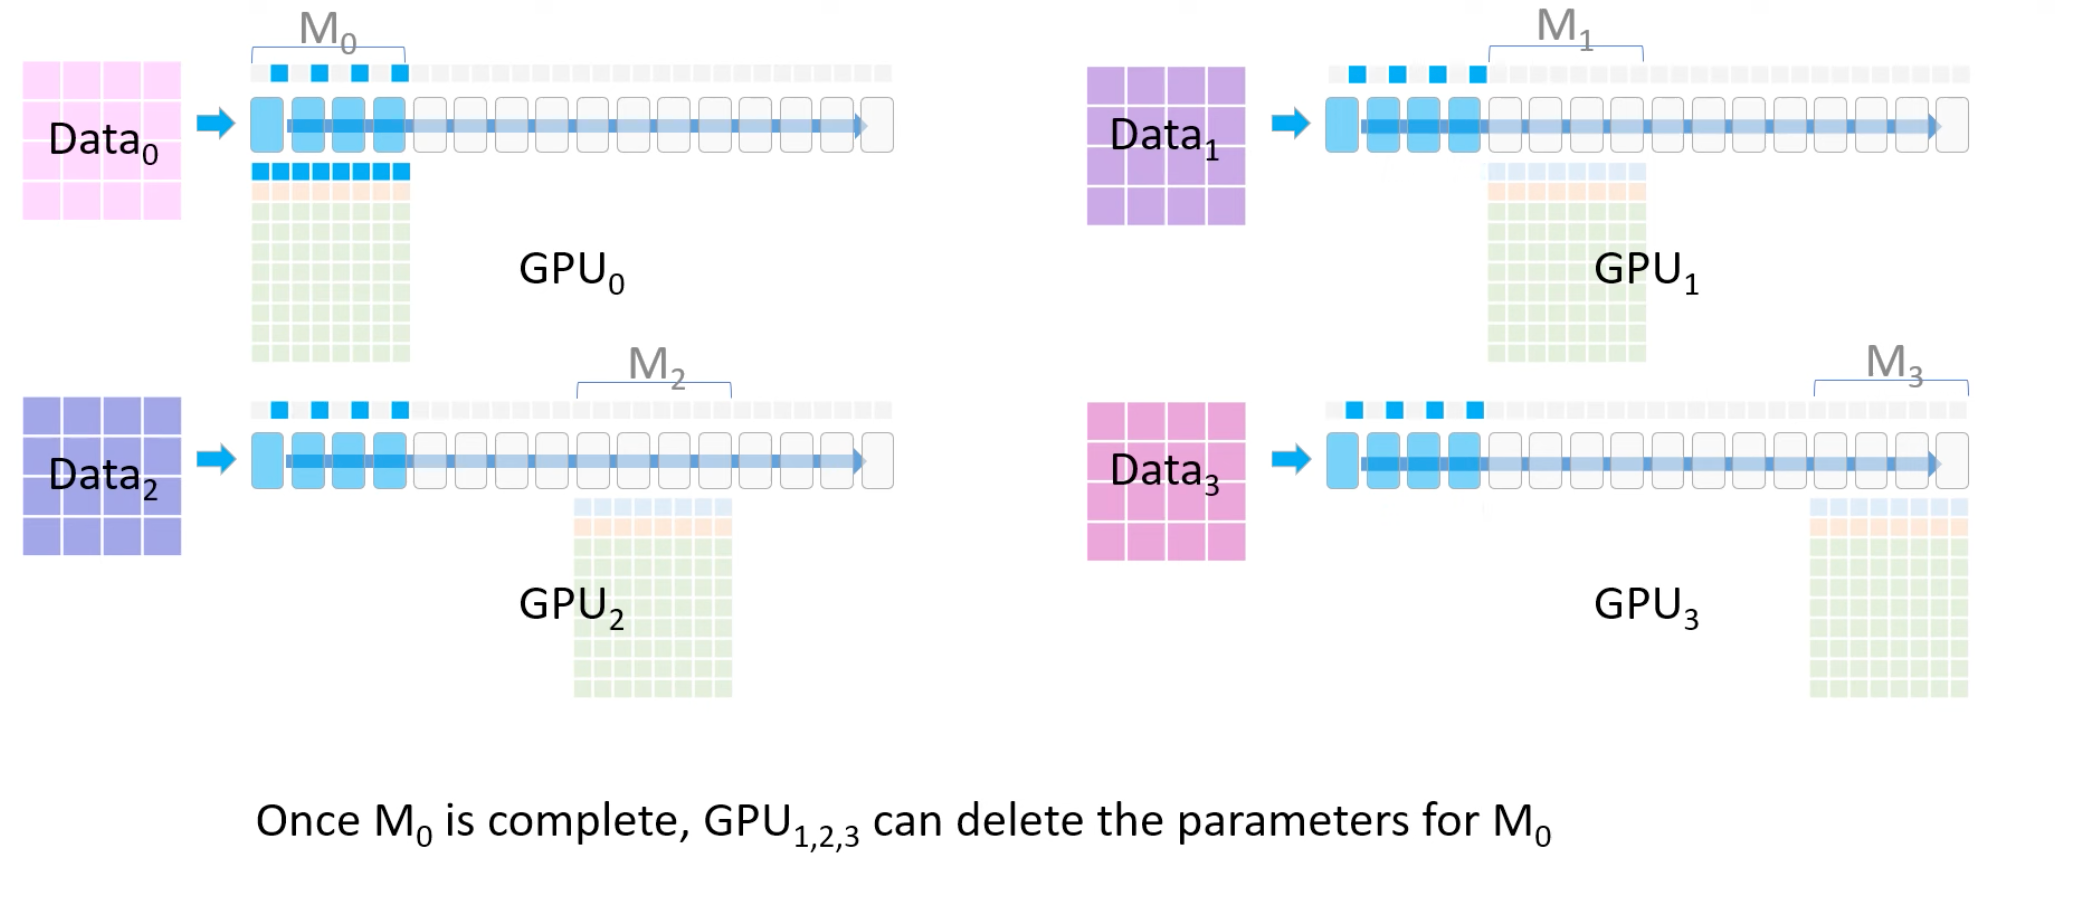

In [9]:
Image('../../imgs/m0_delete.png', width=700)

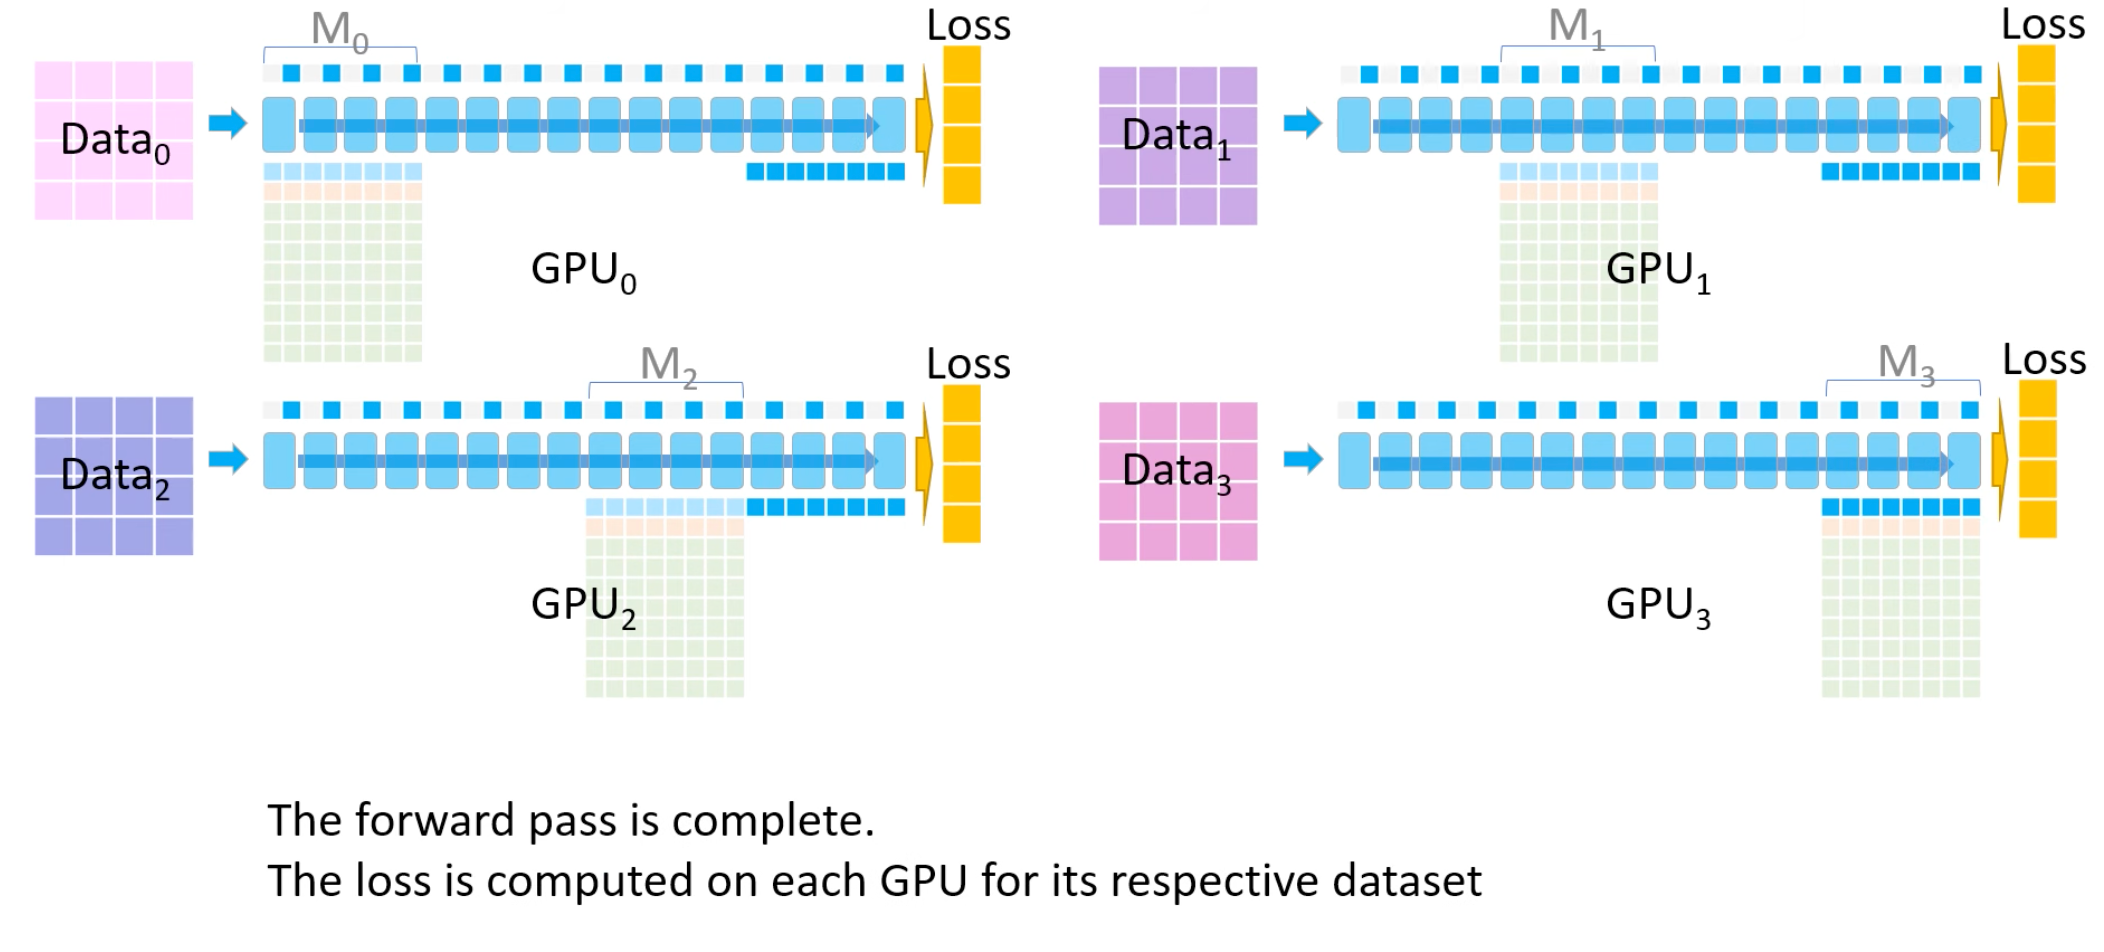

In [11]:
Image('../../imgs/ds_loss.png', width=700)

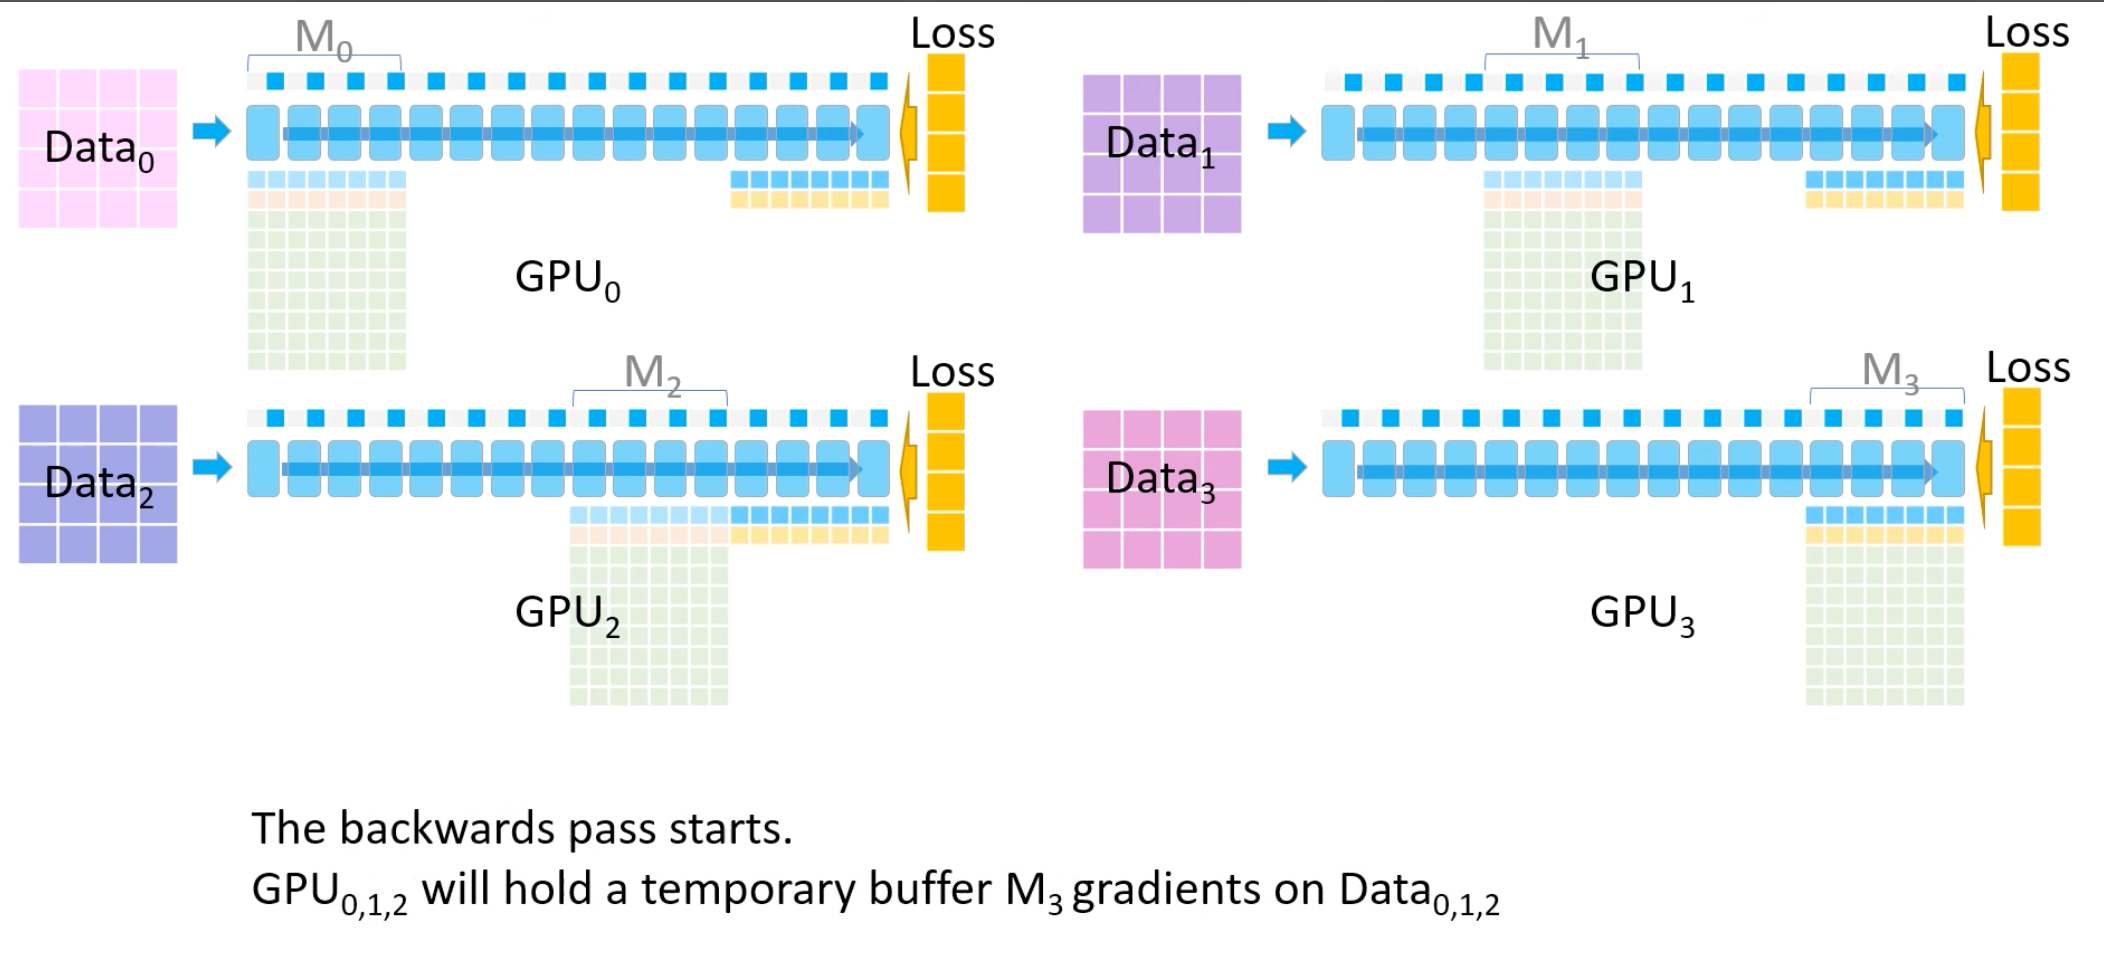

In [12]:
Image('../../imgs/ds_loss_bp.png', width=700)

## examples

### with huggingface transformers

- DeepSpeed is integrated with the Trainer class and most of the setup is automatically taken care of for you.

### example

- `git clone https://github.com/huggingface/transformers.git`：源码下载，
    - `pip install git+https://github.com/huggingface/transformers.git`: 源码安装

```
deepspeed examples/pytorch/translation/run_translation.py \
--deepspeed tests/deepspeed/ds_config_zero3.json \
--model_name_or_path t5-small --per_device_train_batch_size 1 \
--output_dir output_dir --overwrite_output_dir --fp16 \
--do_train --max_train_samples 500 --num_train_epochs 1 \
--dataset_name wmt16 --dataset_config "ro-en" \
--source_lang en --target_lang ro
```

- a key appeal of ZeRO is that **no model code modifications** are required. 
    -  using ZeRO in a DeepSpeed model is quick and easy because all you need is to change a few configurations in the DeepSpeed configuration JSON. **No code changes are needed.**

- 启动日志
    - `NotImplementedError: Using RTX 4000 series doesn't support faster communication broadband via P2P or IB. Please set `NCCL_P2P_DISABLE="1"` and `NCCL_IB_DISABLE="1" or use `accelerate launch` which will do this automatically.`
        - `export NCCL_IB_DISABLE=1`
        - `export NCCL_P2P_DISABLE=1`
    - `--master_addr=127.0.0.1 --master_port=29500`，默认会占用的端口号
        - 分布式 gpu 进程组设置的主节点（master node）
        - 程序异常退出时，有可能未释放该端口号；